The helper notebook for working with the HPC data is at:

https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/load_hcp.ipynb#scrollTo=ZDFPnQ07MmEd

Here's our Google document page:
https://docs.google.com/document/d/1fwsahOvw2Bo7AQYJqk0W3UiRCWFUSFjK3LRRlN9t5cY/edit

Here's the page for the HCP tasks:
https://protocols.humanconnectome.org/HCP/3T/task-fMRI-protocol-details.html



*   Get RS BOLD responses per subject for each parcel
*   Get mean responses
*   Group parcels into given networks and average activity
*   Z-score for standardization
*   Use linear regression model to predict subject's task performance based on activity in each network (all network regions as regressors)






### **Load Libraries & Set Default Values**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import statsmodels.api as sm

# Necessary for visualization
# !pip install nilearn --quiet
# from nilearn import plotting, datasets

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [ ]:
 # The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339
# N_SUBJECTS = 10

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

### **Load Data Set**

In [ ]:
# Altas for visualization
# fname = f"{HCP_DIR}/atlas.npz"
# if not os.path.exists(fname):
#   !wget -qO $fname https://osf.io/j5kuc/download

# Resting state
fname = "hcp_rest.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/bqp7m/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

# Creates a dictionary of parcelated regions
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

In [ ]:
# Non-Resting State

# # Task
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

# Behavioral covariates
fname = "hcp_covariates.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/x5p4g/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

# Data loading

In [ ]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev = dict(zip(["onset", "duration", "amplitude"], np.genfromtxt(ev_file).T))
    evs.append(ev)
  return evs

In [ ]:
# Task-based analysis

def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

# Resting analysis

In [ ]:
timeseries = load_timeseries(subject=0, name="rest", runs=1)
print(timeseries.shape)  # n_parcel x n_timepoint

(360, 1200)


In [ ]:
timeseries_rest = []
for subject in subjects:
  ts_concat = load_timeseries(subject, "rest")
  timeseries_rest.append(ts_concat)

In [ ]:
meanResponsesArray = []
N_SUBJECTS = 339

# Put the standardized mean activity for each parcel (column) and each subject (row)
for subjNum in range(0, N_SUBJECTS): # use N_SUBJECTS for everyone
  # Load the first resting state run for the subject in order to initialize the array
  thisSubj = load_timeseries(subjNum, 'rest', runs=None, remove_mean=False)
  # Load the other 3 runs
  # for runNum in range(1,4):
  #   thisSubj = thisSubj + load_timeseries(subjNum, 'rest', runs=runNum, remove_mean=False)
  # # Get the mean of the four runs
  # meanValues = thisSubj / 4
  # Get the mean for each parcel over the entire timecourse & transpose
  meanAcrossTime = np.mean(thisSubj, axis=1).T
  # Standardize it and add it to the array of subjects
  # meanResponsesArray.append(stats.zscore(meanAcrossTime))
  meanResponsesArray.append(meanAcrossTime)

meanRestResponses = pd.DataFrame(meanResponsesArray)
meanRestResponses

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359
0,11171.257979,9688.591715,10831.542262,11133.180710,10565.569952,10470.973960,10554.898481,9167.204992,8743.047827,10750.739800,9932.438750,10087.160894,10592.794469,12273.781021,10696.439246,9700.813433,9352.499217,9949.111017,10340.481750,9441.354135,8711.218810,9277.367788,8848.663512,9925.611540,8509.136879,13581.047813,10044.688748,8819.057869,10032.904479,10981.375960,12787.651896,11528.711938,12840.721417,11539.051875,11635.395083,9246.996825,10284.126663,11168.024375,9283.165017,10883.749437,...,9413.828696,10770.852377,9751.880200,8887.251175,9912.586838,10163.433554,8480.048790,8649.336488,9132.921519,9429.605156,9771.749492,9692.187813,11866.211271,10972.829121,11620.644792,7975.356315,9425.005915,9746.952575,9152.123633,11345.681917,11425.764479,11479.491250,10314.579729,8175.469133,11179.423046,8018.937304,11710.643854,11468.659938,13426.699021,14530.383313,13429.920854,9622.496702,10098.026596,10101.394990,8816.473706,10775.193000,6650.397990,12043.606208,14868.095146,15655.723354
1,9567.117296,8335.720410,10824.138396,9867.351460,9251.567371,8790.511727,8947.515537,8959.164446,8344.972183,8554.342860,9161.827152,8870.887513,10356.829521,12321.335792,10863.048417,10037.666940,10338.132742,7915.160642,9772.847604,8840.460667,8104.825858,7413.053621,8314.769419,9508.239369,8426.117835,13251.168729,10715.577375,8377.105738,10620.954848,11318.354479,12445.573979,12035.010146,12371.820354,12067.036063,11649.922792,9492.217660,10364.823110,11174.663333,9043.379969,10782.115604,...,9351.728171,11199.250271,9097.407038,9836.068035,9677.808056,10000.334165,9455.925675,9081.709310,9082.743165,8784.895925,8748.447956,10324.860650,12309.439417,10300.934283,9630.887690,9230.240792,9546.754431,9694.128656,9296.570271,11842.440562,11359.389604,11715.082938,10031.685804,9976.159402,7026.998592,12012.638542,12215.008292,11745.001604,13567.584917,14404.768354,14330.653583,11255.710292,10648.058812,9857.384608,9380.639471,10798.612823,8745.321773,12369.287271,15344.649271,15466.986937
2,11286.569438,9355.212669,10091.624223,11134.009708,10386.110042,10415.869167,10265.198998,9217.969925,8861.409262,9929.679969,10237.185121,9697.075312,9941.388404,11891.308000,10059.876537,9296.396452,9320.680515,9549.050963,10125.992881,9394.852556,8236.875777,9209.027363,8543.087244,9166.504377,8317.385313,13755.138896,9474.367223,9192.744998,9079.962590,10917.752250,12363.411958,11398.536083,12107.732750,11363.545479,11186.176333,9439.798854,9859.813340,10778.893958,9146.027650,10599.826250,...,9629.006415,10665.897500,9696.274783,9024.669256,9811.000960,9899.826194,8544.804810,8868.717887,9129.498296,9517.708754,9614.782860,9132.469088,12331.895604,11816.248812,12244.174812,9030.405044,9351.022525,10182.950829,8952.846775,12233.056687,10310.035860,10650.376479,11307.087312,6001.028010,8402.706606,9344.405462,12123.132396,11983.282312,13217.658771,13924.581646,12563.863542,8507.173108,10849.624938,9567.278233,8788.418100,10632.047854,8740.523900,12068.944833,14416.363229,15122.649792
3,11102.285333,9001.692629,9875.265046,11127.572417,10428.824610,10222.305190,11023.812688,8683.943158,8095.847848,8671.786446,9558.763523,8844.325785,10014.628065,11976.992729,10174.819081,9219.934029,9200.207098,10917.218750,9915.202606,9303.984704,8313.936652,8853.125481,8405.415810,9808.404879,8306.849869,12172.266750,9159.879708,9145.699492,8808.782367,10682.808396,12174.055875,11467.415646,12308.542312,11346.699854,11423.120604,8384.032298,9361.372835,10501.826444,8191.889008,10005.951252,...,10566.884563,10727.726729,10383.582292,9771.104156,9774.805108,10556.513792,9326.085671,9247.521673,9677.272142,10451.048292,10062.590329,9397.072217,12956.859750,11928.951167,12803.087104,9092.261281,

In [ ]:
allNetworks = np.unique(region_info["network"])
networksDF = pd.DataFrame(region_info["network"])
networkActivityRest = pd.DataFrame()

for networkNum in range(0, len(allNetworks)):
  thisNetwork = networksDF[0].where(networksDF[0] == allNetworks[networkNum]).dropna()
  # networkActivity[allNetworks[networkNum]] = stats.zscore(meanRestResponses[thisNetwork.index].T.mean())
  networkActivityRest[allNetworks[networkNum]] = meanRestResponses[thisNetwork.index].T.mean()

networkActivityRest

,Auditory,Cingulo-Oper,Default,Dorsal-atten,Frontopariet,Language,Orbito-Affec,Posterior-Mu,Somatomotor,Ventral-Mult,Visual1,Visual2
0,10186.293480,11822.660174,10553.866935,9602.093915,11282.584825,9434.382406,11227.945485,11600.615305,9770.413943,7752.291779,11482.567556,9874.110846
1,10035.347912,11930.430708,10741.786789,9596.086554,11338.866018,9240.565912,12834.970885,11203.977783,9972.759428,8364.339430,10958.705405,9556.750925
2,9771.441998,11612.860932,10400.246026,9207.019572,10966.132589,9359.553262,11395.234981,11066.865107,9831.700734,8078.928331,11735.076007,9874.398981
3,10293.325863,11604.572562,10347.451241,9794.931590,10927.451925,9580.478372,12230.088094,11129.419561,9605.932065,8189.198354,11574.078120,10133.193724
4,10343.409570,11804.590262,10662.237337,10657.194618,10832.234323,10843.072896,11598.781897,10875.790044,10714.046945,8902.184041,11793.051065,11169.563199
...,...,...,...,...,...,...,...,...,...,...,...,...
334,10512.260137,11678.438736,10844.028888,10269.512533,11182.186992,10133.092366,12146.008032,11136.913597,9997.100672,8839.400879,11756.782240,10681.235601
335,9710.338955,11777.327365,10370.950634,10117.940090,11010.077796,10043.756954,10458.349795,10690.644048,10460.796167,7309.449357,12131.327642,10761.341466
336,10853.157845,12256.085522,10864.149515,10280.792766,11004.918174,10431.442507,10791.426597,10744.853911,10883.914282,6775.010580,11695.445201,10863.912743
337,9946.599837,11713.683524,10662.638652,9743.973859,11176.169058,9973.938367,11345.095825,11017.611023,10260.225469,8260.998209,11395.723753,10331.958692


# Task Analysis

#### Task Analysis



- MOTOR: cue, lf, lh, rf, rh, t
- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools, 
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
- EMOTION: feat, neutral
- GAMBLING: loss, loss_event, win, win_event, neut_event
- LANGUAGE:
    cue,
    math, story
    present_math, present_story,
    question_math, question_story,
    response_math, response_story
- RELATIONAL: error, match, relation
- SOCIAL: mental_resp, mental, other_resp, rnd

In [ ]:
# Load each subject's data for a specific task, separately for each run
timeseries_task = []
for subject in range(0, N_SUBJECTS):
  timeseries_task.append(load_timeseries(subject, "relational", concat=False))

In [ ]:
# Run a simple subtraction analysis
task = "relational"
conditions = ["relation", "match"]  # Run a subtraction analysis between two conditions

contrast = []
for subject in range(0, N_SUBJECTS):

  # Get the average signal in each region for each condition
  evs = [load_evs(subject, task, cond) for cond in conditions]
  avgs = [selective_average(timeseries_task[subject], ev) for ev in evs]

  # Store the region-wise difference
  contrast.append(avgs[0] - avgs[1])

contrastDF = pd.DataFrame(contrast)
# contrastDF
# group_contrast = np.mean(contrast, axis=0)
# group_contrast

# Make a data frame for al of the networks
allNetworks = np.unique(region_info["network"])
networksDF = pd.DataFrame(region_info["network"])

# Put the activity into a data frame that matches the task activty DF
taskActivity = pd.DataFrame()
taskActivityStand = pd.DataFrame()

for networkNum in range(0, len(allNetworks)):
  # get the indicies for the current network
  thisNetwork = networksDF[0].where(networksDF[0] == allNetworks[networkNum]).dropna()
  # pull those indicies out of the contrast dataframe for each subject and insert the mean into the task activity
  # taskActivity[str(allNetworks[networkNum])] = stats.zscore(contrastDF[thisNetwork.index].T.mean())
  taskActivity[str(allNetworks[networkNum])] = contrastDF[thisNetwork.index].T.mean()
  taskActivityStand[str(allNetworks[networkNum])] = stats.zscore(contrastDF[thisNetwork.index].T.mean())

taskActivity

,Auditory,Cingulo-Oper,Default,Dorsal-atten,Frontopariet,Language,Orbito-Affec,Posterior-Mu,Somatomotor,Ventral-Mult,Visual1,Visual2
0,-49.625570,-25.704680,-32.106452,-29.680839,-30.361777,-22.465451,-14.078261,-24.154511,-27.647014,-0.183569,-26.303623,-16.821217
1,-15.856473,0.740740,-6.178888,-6.323996,5.508983,5.475419,14.206280,-2.397516,-5.340076,3.718279,-7.816063,-0.989870
2,-22.104072,-16.784847,-11.513453,-16.115352,-6.578357,-6.322215,-11.630966,-15.161989,-14.647057,-8.574040,-5.404227,-9.613245
3,-14.904928,-17.156781,-13.856333,-9.198333,-13.071510,-5.763116,-9.592500,-20.182733,-16.868261,-18.544909,-10.115459,-11.359777
4,2.752058,7.899977,7.449553,25.077464,9.452004,13.023926,-32.329577,15.883880,-8.547323,25.530870,24.374481,45.250368
...,...,...,...,...,...,...,...,...,...,...,...,...
334,-23.812551,-18.261303,-20.065970,-13.839286,-14.075141,0.252757,-26.210121,-30.645710,-19.407085,-14.256359,-10.432850,-9.504760
335,-17.443440,-12.779890,-12.227955,-13.050518,-12.146261,-6.690088,-6.170495,-12.376056,-10.506509,-8.536848,-22.701208,-7.628949
336,-15.870135,-11.620911,-18.392691,-13.136491,-15.956648,-7.815400,-15.039541,-22.693251,-11.198064,-11.567627,-12.574879,-8.168517
337,-3.357174,-6.536093,-9.559225,-9.423841,-3.953320,-12.878179,0.428804,1.057252,-9.421269,-11.524058,-5.591546,-14.159032


In [ ]:
taskActivity["Frontopariet"]

0     -30.361777
1       5.508983
2      -6.578357
3     -13.071510
4       9.452004
         ...    
334   -14.075141
335   -12.146261
336   -15.956648
337    -3.953320
338   -19.094496
Name: Frontopariet, Length: 339, dtype: float64

In [ ]:
#Behavioral Data Information
#have accuracies for working memory, emotion, language, relational
#gambling and social have behavioral data but no measure of task performance since there is no right or wrong answer
#no behavioral data for motor task

#RELATIONAL TASK
relational_behavior = np.genfromtxt("hcp/behavior/relational.csv",
                            delimiter=",",
                            names=True,
                            dtype=None,
                            encoding="utf")
print(relational_behavior.dtype.names)
print(relational_behavior[0])

relational_behavior_run1_match = pd.DataFrame(relational_behavior[0::4]) #behavioral data for run1 match condition
relational_behavior_run1_match_acc = relational_behavior_run1_match['ACC'] #accuracies for run1 match condition
relational_behavior_run1_rel = pd.DataFrame(relational_behavior[1::4]) #behavioral data for run1 rel condition
relational_behavior_run1_rel_acc = relational_behavior_run1_rel['ACC'] #accuracies for run1 rel condition
# relational_behavior_run2_match = pd.DataFrame(relational_behavior[2::4]) #behavioral data for run2 match condition
# relational_behavior_run2_match_acc = relational_behavior_run1_match['ACC']) #accuracies for run2 match condition
# relational_behavior_run2_rel = pd.DataFrame(relational_behavior[3::4]) #behavioral data for run2 rel condition
# relational_behavior_run2_rel_acc = relational_behavior_run1_rel['ACC']) #accuracies for run2 rel condition
print(relational_behavior_run1_match_acc)

#EMOTION TASK 
emotion_behavior = np.genfromtxt("hcp/behavior/emotion.csv",
                            delimiter=",",
                            names=True,
                            dtype=None,
                            encoding="utf")
print(emotion_behavior.dtype.names)
print(emotion_behavior[0])

emotion_behavior_run1_face = pd.DataFrame(emotion_behavior[0::4]) #behavioral data for run1 face
emotion_behavior_run1_face_acc = emotion_behavior_run1_face['ACC'] #accuracies for run1 face
emotion_behavior_run1_shape = pd.DataFrame(emotion_behavior[1::4]) #behavioral data for run1 rel shape
emotion_behavior_run1_shape_acc = emotion_behavior_run1_shape['ACC'] #accuracies for run1 shape
# emotion_behavior_run2_face = pd.DataFrame(emotion_behavior[2::4]) #behavioral data for run2 face
# emotion_behavior_run2_face_acc = emotion_behavior_run1_face(['ACC'] #accuracies for run2 face
# emotion_behavior_run2_shape = pd.DataFrame(emotionl_behavior[2::4]) #behavioral data for run2 rel shape
# emotion_behavior_run2_shape_acc = emotion_behavior_run1_shape['ACC'] #accuracies for run2 shape

#LANGUAGE TASK
language_behavior = np.genfromtxt("hcp/behavior/language.csv",
                            delimiter=",",
                            names=True,
                            dtype=None,
                            encoding="utf")
print(language_behavior.dtype.names)
print(language_behavior[0])

language_behavior_run1_math = pd.DataFrame(language_behavior[0::4]) #behavioral data for run1 math
language_behavior_run1_math_acc = language_behavior_run1_math['ACC'] #accuracies for run1 math
language_behavior_run1_story = pd.DataFrame(language_behavior[1::4]) #behavioral data for run1 story
language_behavior_run1_story_acc = language_behavior_run1_story['ACC'] #accuracies for run1 story
# language_behavior_run2_math = pd.DataFrame(language_behavior[2::4]) #behavioral data for run2 math
# language_behavior_run2_math_acc = language_behavior_run1_math['ACC'] #accuracies for run2 math
# language_behavior_run2_story = pd.DataFrame(language_behavior[3::4]) #behavioral data for run2 story
# language_behavior_run2_story_acc = language_behavior_run1_story['ACC'] #accuracies for run2 story


# #WORKING MEMORY TASK
# #save this for later the number of subjects is wonky
# wm_behavior = np.genfromtxt("hcp/behavior/wm.csv",
#                             delimiter=",",
#                             names=True,
#                             dtype=None,
#                             encoding="utf")
# print(wm_behavior[:16])
# print(wm_behavior[0])
# print(wm_behavior.dtype.names)
# wm_behavior_run1_0BK_BODY = wm_behavior[0::16] #behavioral data for 0back test body
# wm_behavior_run1_0BK_FACE = wm_behavior[1::16] #behavioral data for 0back test faces
# wm_behavior_run1_0BK_PLACE = wm_behavior[2::16] #behavioral data for 0back test place
# wm_behavior_run1_0BK_TOOL = wm_behavior[3::16] #behavioral data for 0back test tool
# wm_behavior_run1_2BK_BODY = wm_behavior[4::16] #behavioral data for 2back test body
# wm_behavior_run1_2BK_FACE = wm_behavior[5::16] #behavioral data for 2back test faces
# wm_behavior_run1_2BK_PLACE = wm_behavior[6::16] #behavioral data for 2back test place
# wm_behavior_run1_2BK_TOOL = wm_behavior[7::16] #behavioral data for 2back test tool
#repeat this indexing for run 2

#VARIABLES SHOWING ACCURACY
#relational_behavior_run1_match_acc, relational_behavior_run1_rel_acc
#emotion_behavior_run1_face_acc, emotion_behavior_run1_shape_acc
#language_behavior_run1_math_acc, language_behavior_run1_story_acc

('Subject', 'Run', 'ConditionName', 'ACC', 'MEDIAN_RT')
(0, 0, 'MATCH', 1., 1693.)
0      1.000000
1      1.000000
2      0.866667
3      0.466667
4      0.800000
         ...   
334    1.000000
335    0.800000
336    0.933333
337    0.933333
338    0.733333
Name: ACC, Length: 339, dtype: float64
('Subject', 'Run', 'ConditionName', 'ACC', 'MEDIAN_RT')
(0, 0, 'FACE', 1., 748.)
('Subject', 'Run', 'ConditionName', 'ACC', 'AVG_DIFFICULTY_LEVEL', 'MEDIAN_RT')
(0, 0, 'MATH', 0.875, 2.42857143, 3713.5)


# Regression Analysis


In [ ]:
# Fit and summarize OLS model
model = sm.OLS(emotion_behavior_run1_shape_acc, taskActivity)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                    ACC   R-squared (uncentered):                   0.666
Model:                            OLS   Adj. R-squared (uncentered):              0.653
Method:                 Least Squares   F-statistic:                              54.24
Date:                Thu, 30 Jul 2020   Prob (F-statistic):                    2.32e-70
Time:                        00:36:00   Log-Likelihood:                         -289.69
No. Observations:                 339   AIC:                                      603.4
Df Residuals:                     327   BIC:                                      649.3
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

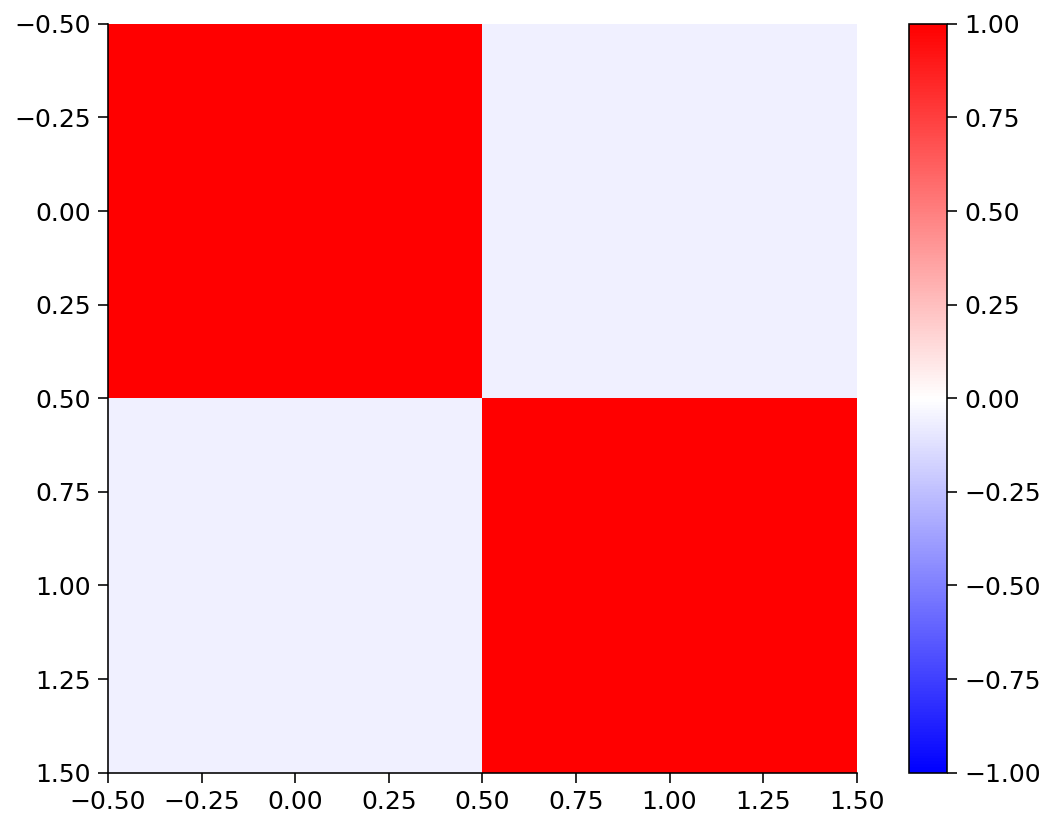

In [ ]:
#use frontoparietal for relational

fc = np.corrcoef(taskActivity["Frontopariet"],networkActivityRest["Frontopariet"])
fc_mean = fc.mean(axis=0)
plt.imshow(fc, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

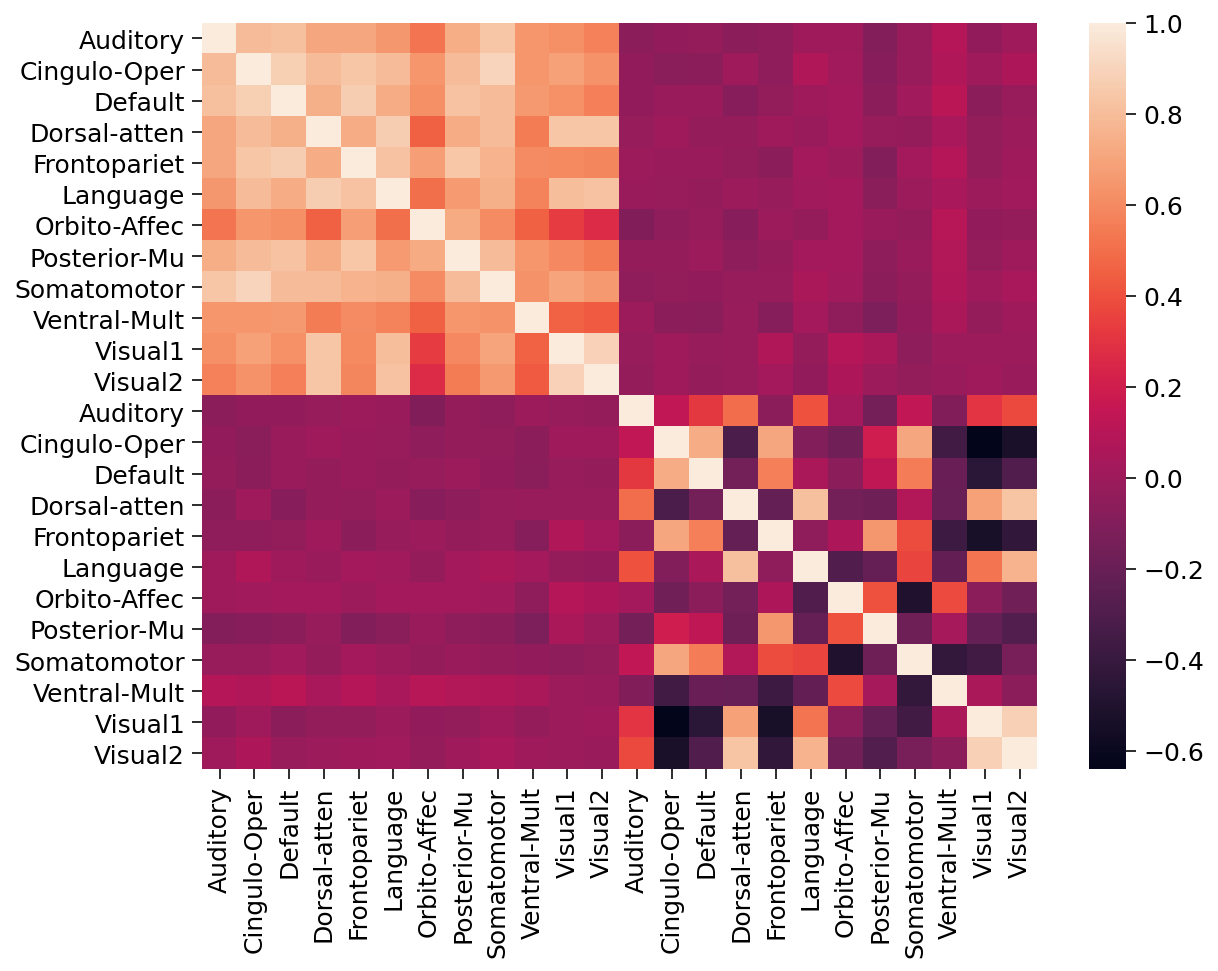

In [ ]:
import seaborn as sn
plt.rcParams['figure.figsize'] = [9, 7]

corrDF = pd.concat([taskActivity, networkActivityRest], axis=1)
# corrDF
corrMatrix = corrDF.corr()
# corrMatrix
sn.heatmap(corrMatrix, annot=False, )
plt.show()

In [ ]:
corrMatrix

,Auditory,Cingulo-Oper,Default,Dorsal-atten,Frontopariet,Language,Orbito-Affec,Posterior-Mu,Somatomotor,Ventral-Mult,Visual1,Visual2,Auditory,Cingulo-Oper,Default,Dorsal-atten,Frontopariet,Language,Orbito-Affec,Posterior-Mu,Somatomotor,Ventral-Mult,Visual1,Visual2
Auditory,1.000000,0.801272,0.813416,0.711308,0.711309,0.648134,0.525637,0.740961,0.833618,0.647148,0.620702,0.567779,-0.063031,-0.044185,-0.029170,-0.058123,-0.045105,0.009679,0.004324,-0.090287,-0.016130,0.093760,-0.038519,0.000694
Cingulo-Oper,0.801272,1.000000,0.876118,0.798746,0.834288,0.800411,0.643313,0.796173,0.902077,0.646028,0.689966,0.634695,-0.038406,-0.070844,-0.063721,0.002201,-0.049130,0.065791,0.015174,-0.079630,-0.016860,0.076329,0.007241,0.061832
Default,0.813416,0.876118,1.000000,0.746708,0.867729,0.735918,0.619603,0.826827,0.797355,0.660463,0.622059,0.559378,-0.040653,-0.007280,-0.010954,-0.077778,-0.035066,0.002741,0.021490,-0.063164,0.016896,0.114276,-0.067577,-0.016443
Dorsal-atten,0.711308,0.798746,0.746708,1.000000,0.736450,0.867321,0.451944,0.732167,0.799860,0.549654,0.835098,0.837742,-0.024654,0.004416,-0.026056,-0.030279,0.013400,-0.008103,0.030292,-0.022825,-0.025655,0.040166,-0.032924,0.000485
Frontopariet,0.711309,0.834288,0.867729,0.736450,1.000000,0.824228,0.678234,0.845882,0.758710,0.605404,0.601646,0.585560,-0.000528,-0.008579,-0.007567,-0.031575,-0.058294,0.029957,-0.002696,-0.097037,0.030817,0.088954,-0.032894,0.011115
Language,0.648134,0.800411,0.735918,0.867321,0.824228,1.000000,0.502951,0.665635,0.747603,0.575110,0.806482,0.826644,-0.008154,-0.014774,-0.030670,0.000408,-0.021389,0.017095,0.029378,-0.072558,-0.002864,0.039949,-0.002691,0.014152
Orbito-Affec,0.525637,0.643313,0.619603,0.451944,0.678234,0.502951,1.000000,0.729547,0.603456,0.450317,0.328267,0.268119,-0.103974,-0.045204,-0.020672,-0.079887,-0.002382,-0.027088,0.028862,-0.007073,-0.027363,0.101266,-0.040787,-0.028205
Posterior-Mu,0.740961,0.796173,0.826827,0.732167,0.845882,0.665635,0.729547,1.000000,0.799279,0.646439,0.591601,0.546523,-0.028802,-0.026263,-0.001987,-0.052607,-0.031054,0.021572,0.021629,-0.051383,-0.008835,0.080453,-0.034181,0.006425
Somatomotor,0.833618,0.902077,0.797355,0.799860,0.758710,0.747603,0.603456,0.799279,1.000000,0.631100,0.704969,0.655616,-0.050354,-0.035910,-0.040999,-0.024453,-0.020210,0.048905,0.017878,-0.062097,-0.025046,0.077140,0.002460,0.039350
Ventral-Mult,0.647148,0.646028,0.660463,0.549654,0.605404,0.575110,0.450317,0.646439,0.631100,1.000000,0.460705,0.430282,-0.003163,-0.062688,-0.070741,-0.017302,-0.082767,0.027380,-0.044848,-0.117620,-0.043825,0.048521,-0.028591,0.007786


In [ ]:
#FC matrix

#grab just a network
FCnetwork = ""


fc = np.zeros((N_SUBJECTS, len(allNetworks), len(allNetworks))
for sub, ts in enumerate(timeseries_rest):
  fc[sub] = np.corrcoef(ts)
#taskActivity vs networkActivityRest

group_fc = fc.mean(axis=0)

plt.imshow(group_fc, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(normalize=False).fit(taskActivity, relational_behavior_run1_rel_acc)
# print('Raw scores:\n', reg.coef_)
reg = LinearRegression(normalize=False).fit(taskActivityStand, relational_behavior_run1_rel_acc)
# print('\nStandardized:\n', reg.coef_)

In [ ]:
for count in range(0, 12):
  reg = stats.linregress(taskActivity.iloc[:, count], relational_behavior_run1_rel_acc)
  # print(allNetworks[count], ": ", reg.pvalue, '   -    ', reg.rvalue)


In [ ]:
import statsmodels.api as sm

gaussian_model = sm.GLM(relational_behavior_run1_rel_acc, taskActivity, family=sm.families.Gaussian())
gaussian_results = gaussian_model.fit()
# print(gaussian_results.summary())

gaussian_model = sm.GLM(relational_behavior_run1_rel_acc, taskActivityStand, family=sm.families.Gaussian())
gaussian_results = gaussian_model.fit()
# print('\n\n', gaussian_results.summary())

In [ ]:
fc = np.zeros((N_SUBJECTS, 1, 1))
for sub, ts in enumerate(timeseries_rest):
  fc[sub] = np.corrcoef(ts)

339

In [ ]:
taskActivity_Network = taskActivity["Frontopariet"]
networkActivityRest_Network = networkActivityRest["Frontopariet"]
taskActivity_Network

0     -30.361777
1       5.508983
2      -6.578357
3     -13.071510
4       9.452004
         ...    
334   -14.075141
335   -12.146261
336   -15.956648
337    -3.953320
338   -19.094496
Name: Frontopariet, Length: 339, dtype: float64

In [ ]:
fc = np.zeros((N_SUBJECTS, 2, 2))
for sub, (tn, rn) in enumerate(zip(taskActivity, networkActivityRest)):
  fc[sub] = np.corrcoef(tn, rn)

group_fc = fc.mean(axis=0)

plt.imshow(fc, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

TypeError: ignored

### **Eric's Sandbox**

In [ ]:
# Detailed information about the name used for each region is provided in the Supplement to Glasser et al. 2016.
# Information about the network parcellation is provided in Ji et al, 2019.
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

# Parcellation on the fsaverage5 surface and approximate MNI coordinates of each region
# with np.load(f"{HCP_DIR}/atlas.npz") as dobj:
#   atlas = dict(**dobj)

In [ ]:
thisSubj = load_timeseries(1, 'rest', runs=None, remove_mean=True)
thisSubj

array([[ 25.13415833,  30.30415833,  77.26415833, ...,  42.148075  ,
          4.358075  ,  54.578075  ],
       [ 60.91121667, 115.05121667, 154.20121667, ...,  40.3838    ,
         31.9838    , -29.6262    ],
       [114.32758333,  95.72758333, 150.62758333, ..., -91.53333333,
        -61.83333333,   7.06666667],
       ...,
       [222.7785    , 164.8785    , 301.3785    , ..., 113.0625    ,
         52.5625    , 138.1625    ],
       [373.24833333, 281.54833333, 371.54833333, ...,  50.01458333,
        110.81458333,  71.31458333],
       [457.0525    , 474.3525    , 469.2525    , ...,  -0.7585    ,
        224.7415    ,  47.1415    ]])

In [ ]:
meanResponsesArray = []
N_SUBJECTS = 339

# Put the standardized mean activity for each parcel (column) and each subject (row)
for subjNum in range(0, N_SUBJECTS): # use N_SUBJECTS for everyone
  # Load the first resting state run for the subject in order to initialize the array
  thisSubj = load_timeseries(subjNum, 'rest', runs=None, remove_mean=False)
  # Load the other 3 runs
  # for runNum in range(1,4):
  #   thisSubj = thisSubj + load_timeseries(subjNum, 'rest', runs=runNum, remove_mean=False)
  # # Get the mean of the four runs
  # meanValues = thisSubj / 4
  # Get the mean for each parcel over the entire timecourse & transpose
  meanAcrossTime = np.mean(thisSubj, axis=1).T
  # Standardize it and add it to the array of subjects
  # meanResponsesArray.append(stats.zscore(meanAcrossTime))
  meanResponsesArray.append(meanAcrossTime)

meanRestResponses = pd.DataFrame(meanResponsesArray)
meanRestResponses

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359
0,11171.257979,9688.591715,10831.542262,11133.180710,10565.569952,10470.973960,10554.898481,9167.204992,8743.047827,10750.739800,9932.438750,10087.160894,10592.794469,12273.781021,10696.439246,9700.813433,9352.499217,9949.111017,10340.481750,9441.354135,8711.218810,9277.367788,8848.663512,9925.611540,8509.136879,13581.047813,10044.688748,8819.057869,10032.904479,10981.375960,12787.651896,11528.711938,12840.721417,11539.051875,11635.395083,9246.996825,10284.126663,11168.024375,9283.165017,10883.749437,...,9413.828696,10770.852377,9751.880200,8887.251175,9912.586838,10163.433554,8480.048790,8649.336488,9132.921519,9429.605156,9771.749492,9692.187813,11866.211271,10972.829121,11620.644792,7975.356315,9425.005915,9746.952575,9152.123633,11345.681917,11425.764479,11479.491250,10314.579729,8175.469133,11179.423046,8018.937304,11710.643854,11468.659938,13426.699021,14530.383313,13429.920854,9622.496702,10098.026596,10101.394990,8816.473706,10775.193000,6650.397990,12043.606208,14868.095146,15655.723354
1,9567.117296,8335.720410,10824.138396,9867.351460,9251.567371,8790.511727,8947.515537,8959.164446,8344.972183,8554.342860,9161.827152,8870.887513,10356.829521,12321.335792,10863.048417,10037.666940,10338.132742,7915.160642,9772.847604,8840.460667,8104.825858,7413.053621,8314.769419,9508.239369,8426.117835,13251.168729,10715.577375,8377.105738,10620.954848,11318.354479,12445.573979,12035.010146,12371.820354,12067.036063,11649.922792,9492.217660,10364.823110,11174.663333,9043.379969,10782.115604,...,9351.728171,11199.250271,9097.407038,9836.068035,9677.808056,10000.334165,9455.925675,9081.709310,9082.743165,8784.895925,8748.447956,10324.860650,12309.439417,10300.934283,9630.887690,9230.240792,9546.754431,9694.128656,9296.570271,11842.440562,11359.389604,11715.082938,10031.685804,9976.159402,7026.998592,12012.638542,12215.008292,11745.001604,13567.584917,14404.768354,14330.653583,11255.710292,10648.058812,9857.384608,9380.639471,10798.612823,8745.321773,12369.287271,15344.649271,15466.986937
2,11286.569438,9355.212669,10091.624223,11134.009708,10386.110042,10415.869167,10265.198998,9217.969925,8861.409262,9929.679969,10237.185121,9697.075312,9941.388404,11891.308000,10059.876537,9296.396452,9320.680515,9549.050963,10125.992881,9394.852556,8236.875777,9209.027363,8543.087244,9166.504377,8317.385313,13755.138896,9474.367223,9192.744998,9079.962590,10917.752250,12363.411958,11398.536083,12107.732750,11363.545479,11186.176333,9439.798854,9859.813340,10778.893958,9146.027650,10599.826250,...,9629.006415,10665.897500,9696.274783,9024.669256,9811.000960,9899.826194,8544.804810,8868.717887,9129.498296,9517.708754,9614.782860,9132.469088,12331.895604,11816.248812,12244.174812,9030.405044,9351.022525,10182.950829,8952.846775,12233.056687,10310.035860,10650.376479,11307.087312,6001.028010,8402.706606,9344.405462,12123.132396,11983.282312,13217.658771,13924.581646,12563.863542,8507.173108,10849.624938,9567.278233,8788.418100,10632.047854,8740.523900,12068.944833,14416.363229,15122.649792
3,11102.285333,9001.692629,9875.265046,11127.572417,10428.824610,10222.305190,11023.812688,8683.943158,8095.847848,8671.786446,9558.763523,8844.325785,10014.628065,11976.992729,10174.819081,9219.934029,9200.207098,10917.218750,9915.202606,9303.984704,8313.936652,8853.125481,8405.415810,9808.404879,8306.849869,12172.266750,9159.879708,9145.699492,8808.782367,10682.808396,12174.055875,11467.415646,12308.542312,11346.699854,11423.120604,8384.032298,9361.372835,10501.826444,8191.889008,10005.951252,...,10566.884563,10727.726729,10383.582292,9771.104156,9774.805108,10556.513792,9326.085671,9247.521673,9677.272142,10451.048292,10062.590329,9397.072217,12956.859750,11928.951167,12803.087104,9092.261281,

In [ ]:
# import statsmodels.api as sm
# gaussian_model = sm.GLM(relational_behavior_run1_match_acc, networkActivity, family=sm.families.Gaussian())
# gaussian_results = gaussian_model.fit()
# print(gaussian_results.summary())

from sklearn.linear_model import LinearRegression
reg = LinearRegression(normalize=True).fit(networkActivity, relational_behavior_run1_match_acc)
reg.coef_
# reg.score(networkActivity, relational_behavior_run1_match_acc)

12

In [ ]:
allNetworks = np.unique(region_info["network"])
networksDF = pd.DataFrame(region_info["network"])
networkActivity = pd.DataFrame()

for networkNum in range(0, len(allNetworks)):
  thisNetwork = networksDF[0].where(networksDF[0] == allNetworks[networkNum]).dropna()
  # networkActivity[allNetworks[networkNum]] = stats.zscore(meanRestResponses[thisNetwork.index].T.mean())
  networkActivity[allNetworks[networkNum]] = meanRestResponses[thisNetwork.index].T.mean()

networkActivity

,Auditory,Cingulo-Oper,Default,Dorsal-atten,Frontopariet,Language,Orbito-Affec,Posterior-Mu,Somatomotor,Ventral-Mult,Visual1,Visual2
0,10186.293480,11822.660174,10553.866935,9602.093915,11282.584825,9434.382406,11227.945485,11600.615305,9770.413943,7752.291779,11482.567556,9874.110846
1,10035.347912,11930.430708,10741.786789,9596.086554,11338.866018,9240.565912,12834.970885,11203.977783,9972.759428,8364.339430,10958.705405,9556.750925
2,9771.441998,11612.860932,10400.246026,9207.019572,10966.132589,9359.553262,11395.234981,11066.865107,9831.700734,8078.928331,11735.076007,9874.398981
3,10293.325863,11604.572562,10347.451241,9794.931590,10927.451925,9580.478372,12230.088094,11129.419561,9605.932065,8189.198354,11574.078120,10133.193724
4,10343.409570,11804.590262,10662.237337,10657.194618,10832.234323,10843.072896,11598.781897,10875.790044,10714.046945,8902.184041,11793.051065,11169.563199
...,...,...,...,...,...,...,...,...,...,...,...,...
334,10512.260137,11678.438736,10844.028888,10269.512533,11182.186992,10133.092366,12146.008032,11136.913597,9997.100672,8839.400879,11756.782240,10681.235601
335,9710.338955,11777.327365,10370.950634,10117.940090,11010.077796,10043.756954,10458.349795,10690.644048,10460.796167,7309.449357,12131.327642,10761.341466
336,10853.157845,12256.085522,10864.149515,10280.792766,11004.918174,10431.442507,10791.426597,10744.853911,10883.914282,6775.010580,11695.445201,10863.912743
337,9946.599837,11713.683524,10662.638652,9743.973859,11176.169058,9973.938367,11345.095825,11017.611023,10260.225469,8260.998209,11395.723753,10331.958692


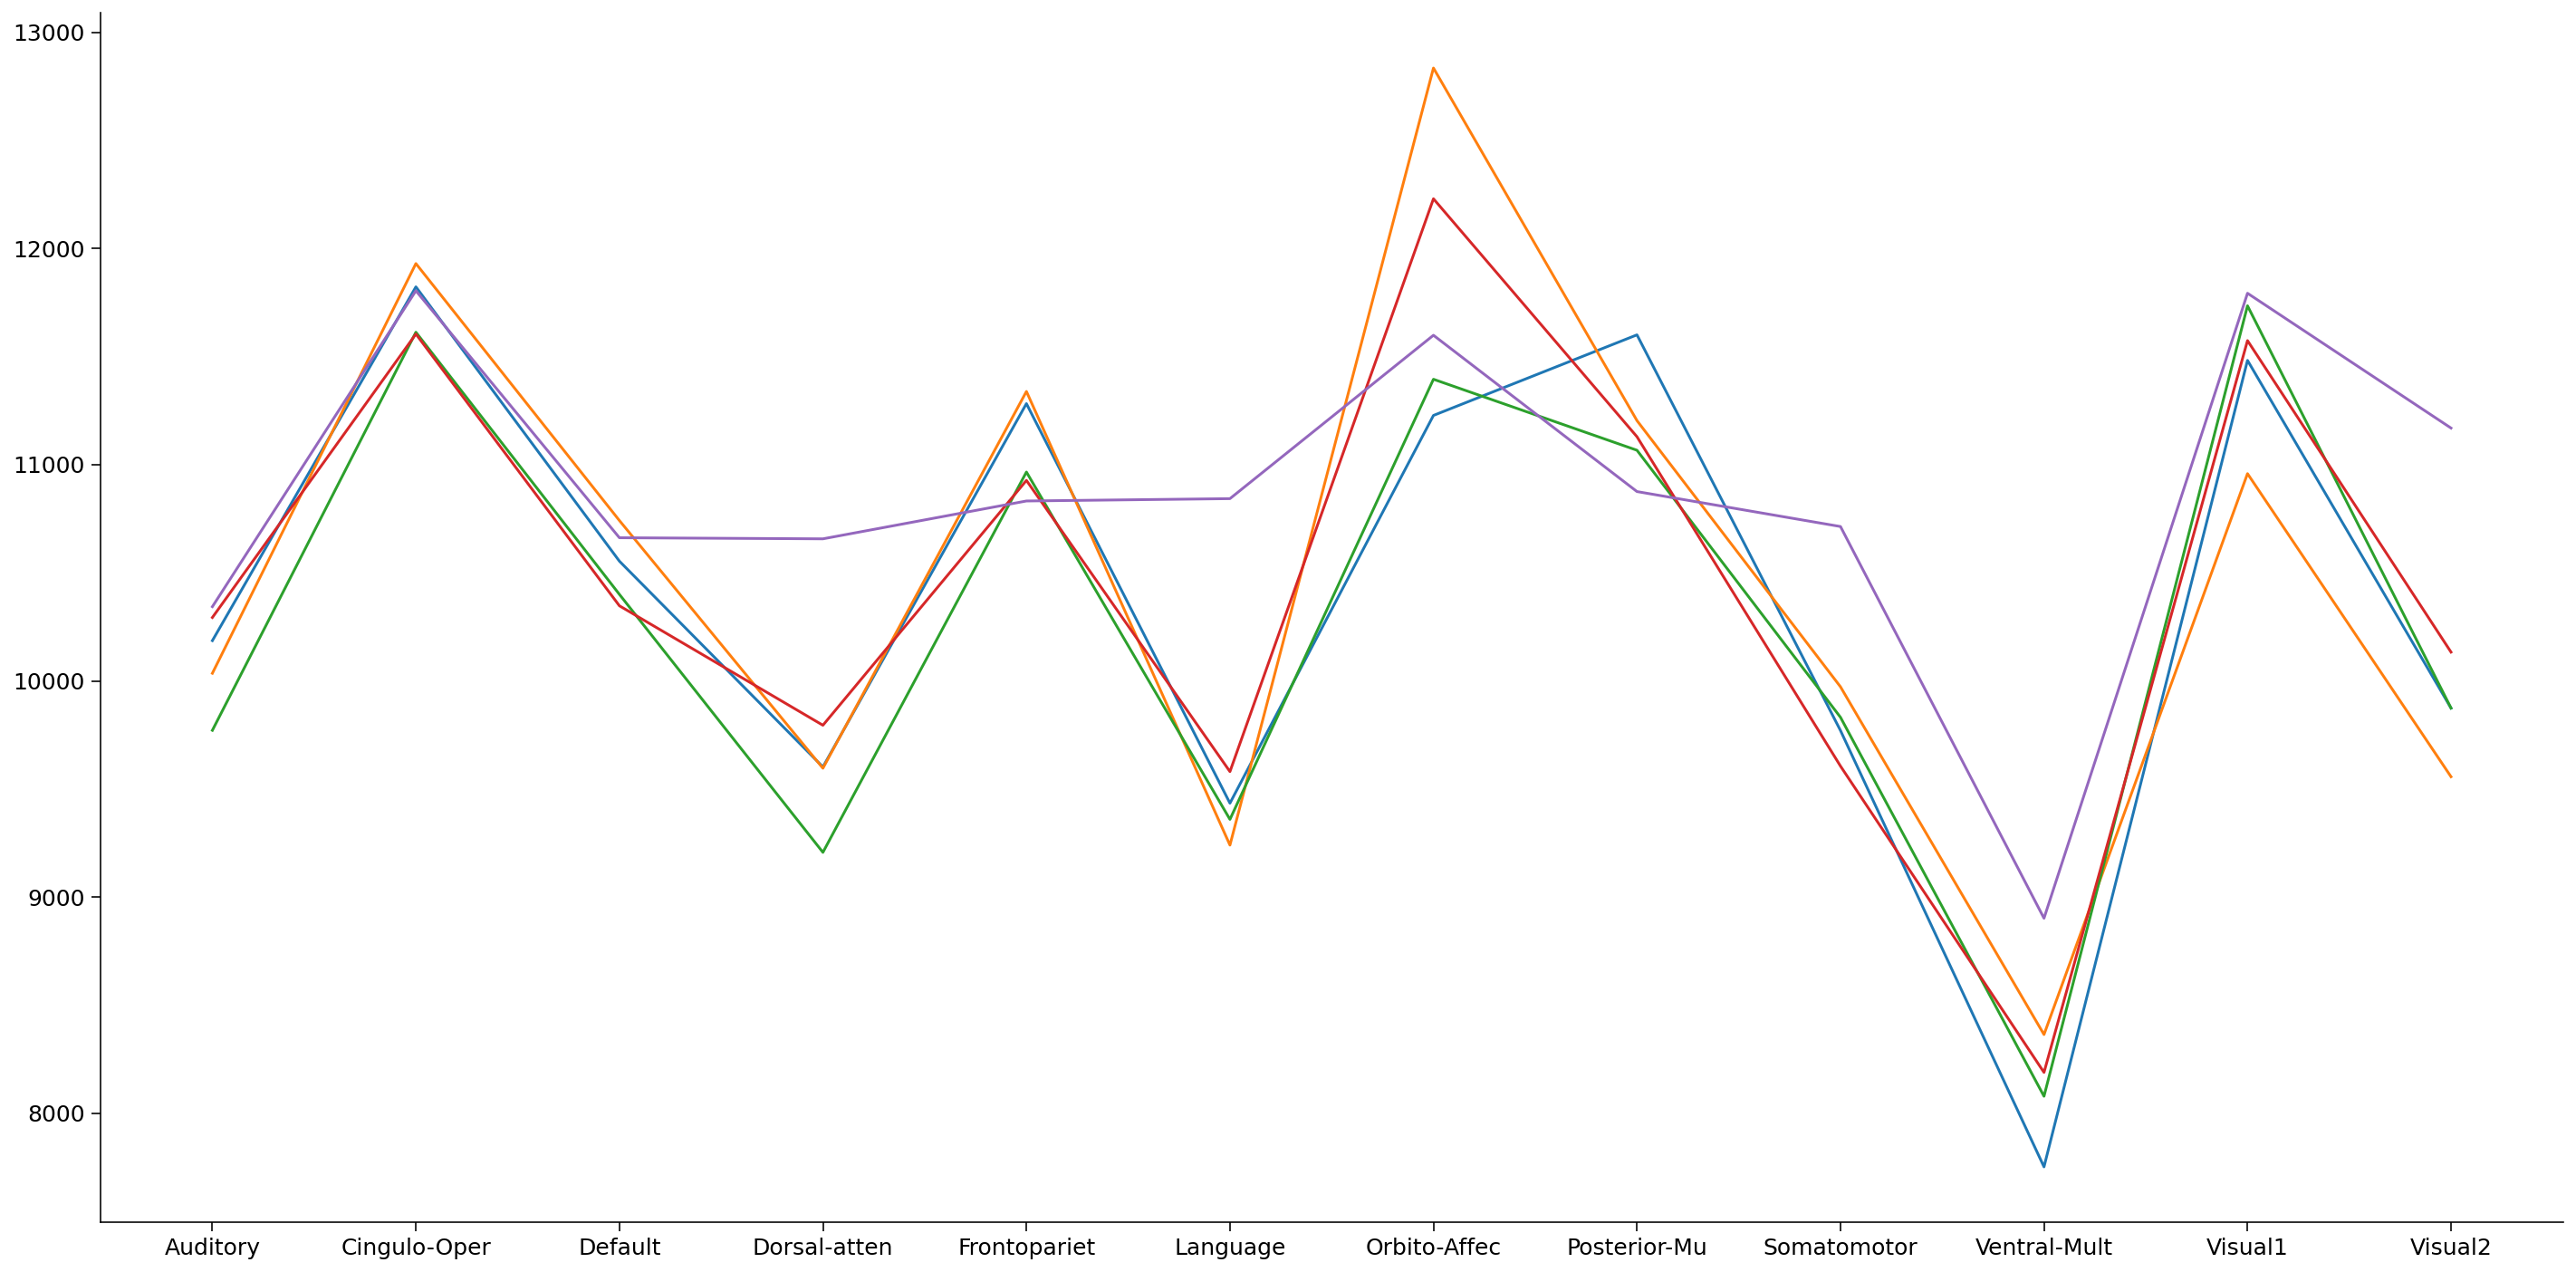

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]

for subjNum in range(0, 5):
  plt.plot(networkActivity.iloc[subjNum, :])

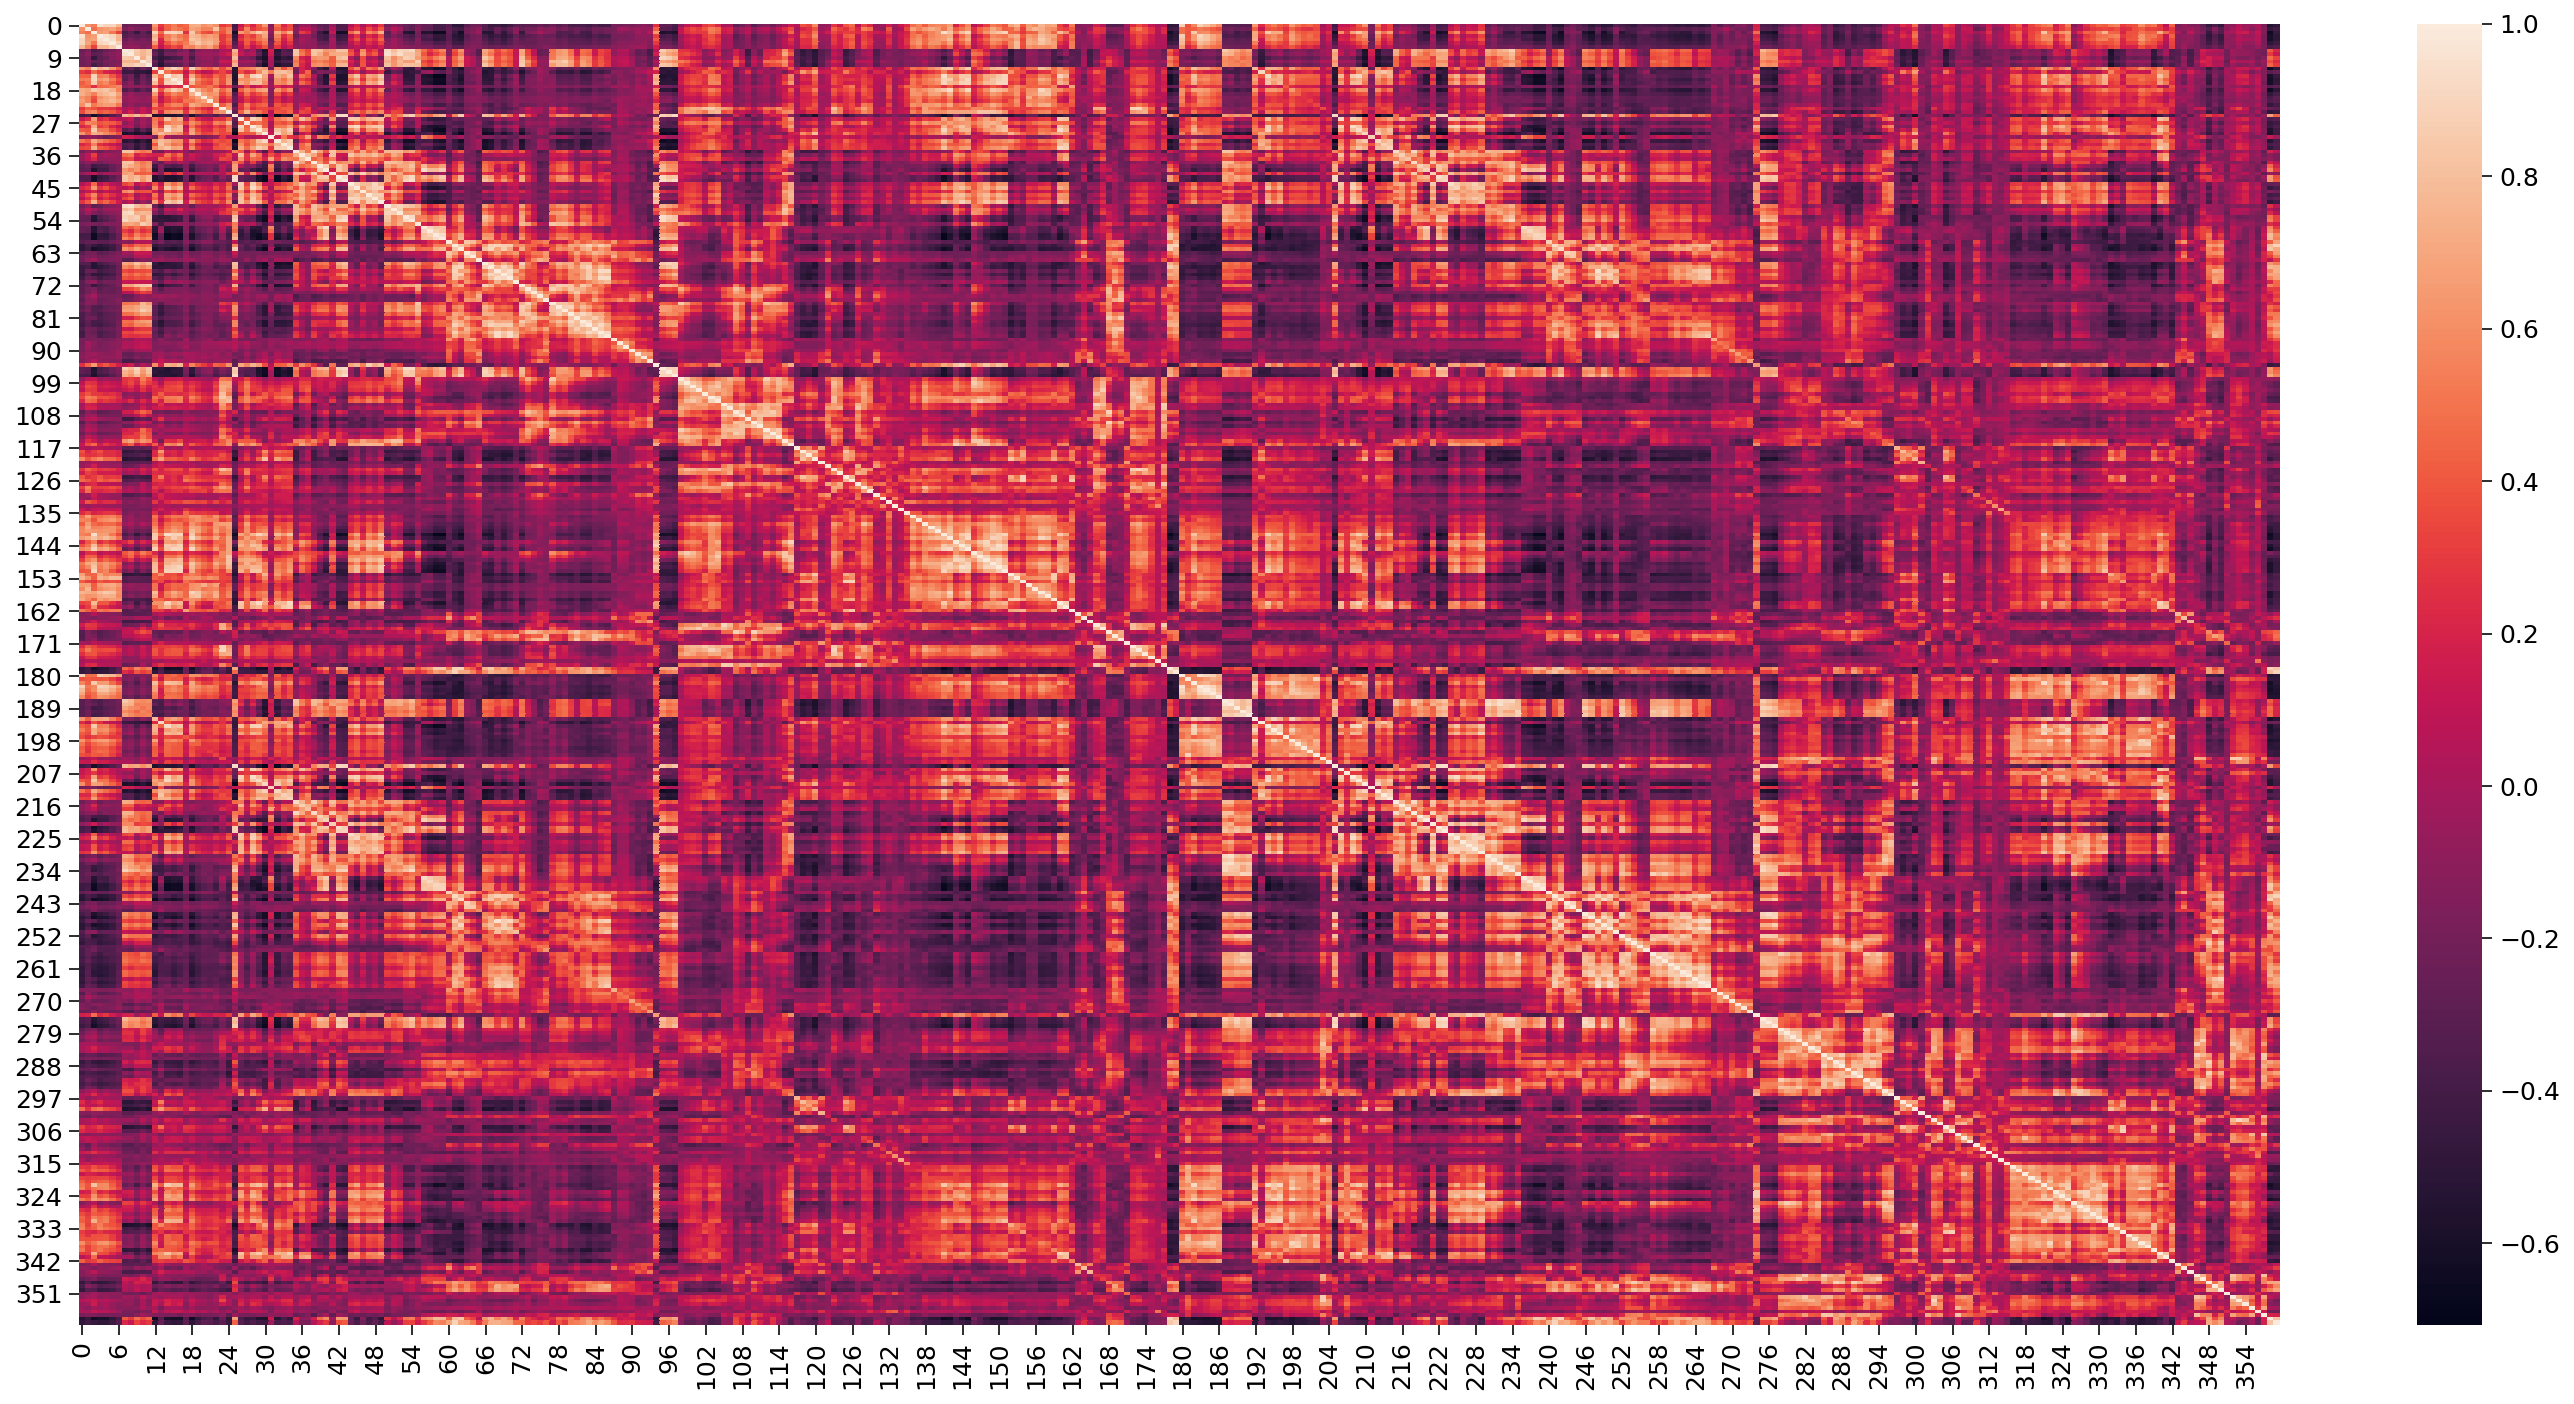

In [ ]:
import seaborn as sn

corrMatrix = meanRestResponses.corr()
sn.heatmap(corrMatrix, annot=False, )
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()

In [ ]:
corrMatrix = meanRestResponses.corr()
corrMatrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359
0,1.000000,0.617153,0.544736,0.957748,0.905976,0.904546,0.775855,-0.249710,-0.205221,-0.219596,-0.224433,-0.230796,0.645824,0.298236,0.436959,0.527433,0.417191,0.462018,0.726256,0.733918,0.617163,0.664698,0.605994,0.297437,0.365379,-0.401074,0.134799,0.347472,0.213162,0.411203,0.635261,-0.147089,0.507628,0.209228,0.346394,-0.200751,-0.060597,-0.057662,-0.167134,-0.292525,...,0.421224,0.505558,0.547457,0.161090,0.309310,0.528361,-0.152562,0.022180,0.253624,0.364373,0.441477,0.422310,0.520222,0.562686,0.304862,0.358555,0.381866,0.601546,0.453861,0.510504,0.294069,0.068972,0.427136,-0.168846,-0.077498,-0.137899,-0.137436,-0.262559,-0.466080,-0.369308,-0.471575,-0.103453,-0.107739,0.058330,-0.047832,-0.054208,0.018210,-0.184226,-0.544570,-0.483377
1,0.617153,1.000000,0.485634,0.621675,0.653367,0.688163,0.578620,-0.170529,-0.098798,-0.175193,-0.155496,-0.187002,0.549296,0.233276,0.427111,0.544465,0.496595,0.438240,0.685175,0.647285,0.548696,0.557216,0.823342,0.429372,0.549827,-0.373233,0.229090,0.571830,0.284594,0.381802,0.452591,-0.068528,0.417893,0.285376,0.363643,-0.108213,0.096321,0.086562,-0.085354,-0.225342,...,0.330392,0.392871,0.385143,0.194079,0.307462,0.423656,-0.045255,0.070839,0.203012,0.289126,0.325368,0.341675,0.308774,0.369322,0.238742,0.264678,0.369189,0.423882,0.317661,0.328816,0.299448,0.159789,0.297743,-0.112927,-0.099670,-0.031015,-0.093598,-0.213037,-0.337051,-0.133108,-0.320251,-0.111761,-0.026388,0.081745,-0.015344,-0.115262,0.014919,-0.153027,-0.469676,-0.406637
2,0.544736,0.485634,1.000000,0.653470,0.686604,0.513277,0.320250,-0.388004,-0.298798,-0.471638,-0.275352,-0.406174,0.900839,0.464786,0.897404,0.909648,0.847903,0.253565,0.850843,0.540292,0.383395,0.337828,0.524182,0.380407,0.574576,-0.610480,0.653516,0.536953,0.706863,0.853947,0.741776,-0.082263,0.719025,0.546646,0.746514,-0.130395,0.308018,0.223896,-0.142693,-0.422871,...,0.393369,0.826045,0.519966,0.447111,0.616586,0.676170,0.067311,0.261091,0.443599,0.414939,0.548423,0.751741,0.440923,0.433322,0.211647,0.379020,0.377579,0.501112,0.430965,0.434901,0.720326,0.466097,0.313939,0.009923,-0.153323,0.098983,-0.096038,-0.159923,-0.460563,-0.207203,-0.336087,-0.016263,-0.006383,0.131896,0.155152,-0.013520,0.111344,-0.155319,-0.627883,-0.462215
3,0.957748,0.621675,0.653470,1.000000,0.948212,0.903452,0.756782,-0.324597,-0.275821,-0.304012,-0.272312,-0.298282,0.743373,0.336229,0.536544,0.629063,0.521003,0.457568,0.789143,0.745033,0.617753,0.675140,0.621164,0.288675,0.396115,-0.475951,0.213168,0.389303,0.305328,0.504497,0.687724,-0.171772,0.569462,0.259902,0.415855,-0.239220,-0.050050,-0.065246,-0.210604,-0.378758,...,0.428733,0.584569,0.565547,0.209438,0.369630,0.575764,-0.141673,0.059628,0.297344,0.378052,0.475709,0.497496,0.538222,0.569879,0.289620,0.370093,0.386935,0.621934,0.480993,0.509835,0.367318,0.111078,0.436042,-0.125270,-0.090138,-0.068135,-0.157188,-0.280701,-0.492149,-0.335281,-0.464756,-0.077595,-0.109177,0.044127,-0.027681,-0.051590,0.060274,-0.199028,-0.597159,-0.498042
4,0.905976,0.653367,0.686604,0.948212,1.000000,0.928020,0.755077,-0.240262,-0.177135,-0.241106,-0.185573,-0.220530,0.800969,0.206553,0.570214,0.694070,0.592816,0.476409,0.828734,0.786570,0.688994,0.716780,0.660125,0.295264,0.452751,-0.435348,0.275782,0.431641,0.377320,0.506565,0.584452,-0.249347,0.481909,0.191798,0.377906,-0.152717,0.012888,-0.068327,-0.126776,-0.354528,...,0.448370,0.591777,0.599323,0.263601,0.436614,0.614942,-0.056979,0.121798,0.354052,0.411250,0.529190,0.551779,0.419165,0.493744,0.219328,0.400559,0.403053,0.645071,0.498956,0.414978,0.356144,0.102668,0.358981,-0.126544,-0.116086,-0.070469,-0.167434,-0.266939,-0.467561,-0.306482,-0.442317,-0.094883,-0.075797,0.051685,0.020742,-0.016698,0.06

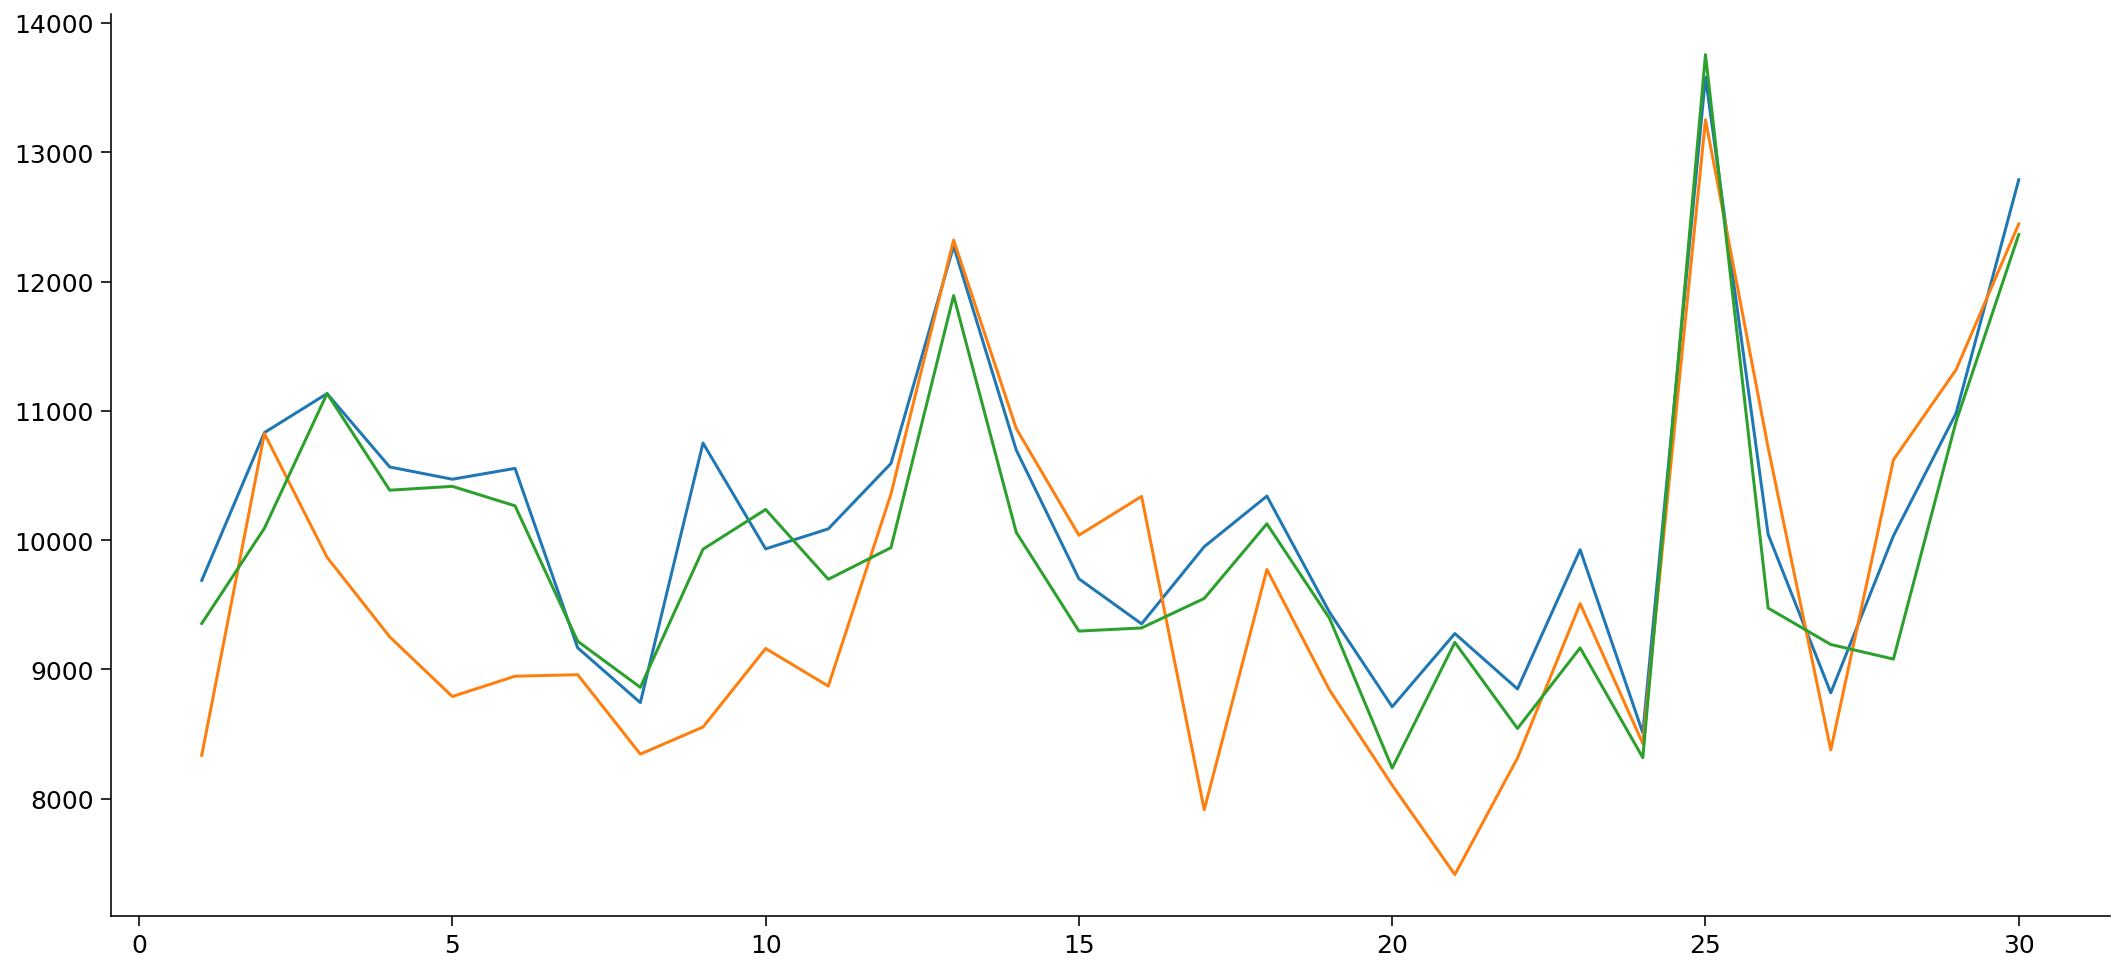

In [ ]:
plt.rcParams['figure.figsize'] = [15, 7]

plt.plot(meanRestResponses.loc[0, 1:30]);
plt.plot(meanRestResponses.loc[1, 1:30]);
plt.plot(meanRestResponses.loc[2, 1:30]);

In [ ]:
plt.rcParams['figure.figsize'] = [15, 7]

# from sklearn.decomposition import FastICA
# ica = FastICA(n_components=7, random_state=0)
# transformedResponses = ica.fit_transform(meanRestResponses)
# # transformedResponses.base
# ica.mixing_
# plt.plot(ica.mixing_[0:150, 1:3])

from sklearn.decomposition import PCA
pca = PCA(n_components=7)
pca.fit(meanRestResponses)
# pca.explained_variance_ratio_
print(pca.components_[0][0:10])
# plt.plot(pca.explained_variance_)
# plt.plot(pca.explained_variance_ratio_)


from sklearn.decomposition import FactorAnalysis
transformer = FactorAnalysis(n_components=7, random_state=0)
transformedResponses = transformer.fit_transform(meanRestResponses.T)
# transformer.transform(meanRestResponses.T)
print(transformedResponses[0][0:10])

# plt.plot(transformer.components_[, 0:50])
# transformedResponses



[-0.04704105 -0.04575363 -0.07648509 -0.05059247 -0.05730379 -0.04589923
 -0.03382614  0.04340832  0.03458214  0.061239  ]
[-0.0353422  -1.24793661 -0.2451781  -0.14971118 -0.58060369 -0.23961615
  2.28277408]
